##Python code to verify the simulation results by using statistic methods
####Reference http://pubs.acs.org/doi/pdfplus/10.1021/ct500040r

In [3]:
import matplotlib.pyplot as plt 
import numpy as np
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.lines as mlines
from scipy.optimize import curve_fit
from scipy.misc import factorial
from scipy.stats import ks_2samp
from scipy import stats

In [4]:
datain=np.genfromtxt('Unfolding rate data(100 trials).txt')
data=datain[: ,1]*1e9
min=np.min(data)
max=np.max(data)
bins=10*np.size(data)

time=np.logspace(np.log10(min),np.log10(max),num=bins)
mu=np.mean(data)

time_centers = np.r_[0.5 * (time[:-1] + time[1:])]

###Poisson process, the cumulative distribution function (CDF)

In [5]:
def analyticalCDF(times,tau):
    return 1-np.exp(-times/tau)

In [6]:
print np.std(data)
print stats.sem(data)

376.902294078
37.8801058206


###Empirical cumulative distribution function(ECDF)

In [7]:
hist, bins2=np.histogram(data,bins=time,density=False)
cdf=np.cumsum(hist)*1.0/data.size

In [8]:
#Fit the CDF 
taufit, pcov = curve_fit(analyticalCDF,time_centers, cdf,mu)
print "mu (ns)\t\t" ,mu
print "taufit (ns)\t" ,taufit[0]

mu (ns)		50.091603327
taufit (ns)	0.652246441386


/Users/michaeltung/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from IPython.kernel.zmq import kernelapp as app


###Make some plots

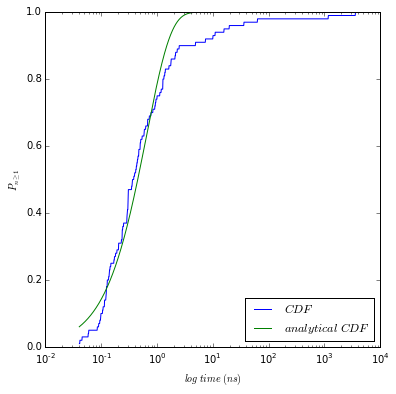

In [9]:
#lets make some plots
%matplotlib inline 
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2)

axes = fig.add_subplot(111)
axes.plot(bins2[1:bins],cdf,label='$CDF$')
axes.set_xscale('log')
axes.plot(time_centers,analyticalCDF(time_centers,taufit),label='$analytical\ CDF$')
first_legend = plt.legend(loc=0)
axes.set_xlabel('$log\ time\ (ns)$')
axes.set_ylabel('$P_{n\geq1}$')
plt.show()

In [10]:
points=1e5
randdata=np.random.gamma(1,taufit,np.size(data)*points)

#perfrom the KS test to see if the data points from MetaD are statistically
#the same as the data points from the analytical fit
stat,p=ks_2samp(data,randdata)

###Statistic Results

In [11]:
#data table: 
print "mu:" , np.mean(data)
print "mu_sem:", stats.sem(data)
print "sigma:", np.std(data,ddof=1) 
print "t_m:", np.median(data)
print "tau:", taufit
print "mu_sigma_ratio:", np.mean(data)/np.std(data,ddof=1)
print "log2mu_median_ratio:", np.log(2)*np.mean(data)/np.median(data)
print "tau_mu_ratio:", taufit/np.mean(data)
print "p-value:" , p
print "ks-stat:" , stat
print "events recorded:" ,  np.size(data)

mu: 50.091603327
mu_sem: 37.8801058206
sigma: 378.801058206
t_m: 0.3737165
tau: [ 0.65224644]
mu_sigma_ratio: 0.132237231766
log2mu_median_ratio: 92.9069324363
tau_mu_ratio: [ 0.01302107]
p-value: 0.248116638054
ks-stat: 0.1007851
events recorded: 100


### Automation to perform thousands of simulations and systematically analyze results

In [12]:
##random sampling on data set
def sampling(data,num_iters,sampsize):
       
    means=np.array([0.0])
    pvals=np.array([0.0])
    points=1e4 #number of sampling points for p-val
    alpha=0.05
    reject=0.0
    
    while np.size(means) <= num_iters: 
        smalldata=np.random.choice(data,sampsize,replace=True)
        #hist / CDF fit / etc
        min=np.min(smalldata)
        max=np.max(smalldata)
        bins=10*np.size(smalldata)
        time=np.logspace(np.log10(min),np.log10(max),num=bins)
        mu=np.mean(smalldata)
        time_centers = np.r_[0.5 * (time[:-1] + time[1:])]
        hist, bins2=np.histogram(smalldata,bins=time,density=False)
        cdf=np.cumsum(hist)*1.0/smalldata.size
        taufit, pcov = curve_fit(analyticalCDF,time_centers, cdf,mu)
        #analysis 
        randdata=np.random.gamma(1,taufit,np.size(smalldata)*points)
        stat,p=ks_2samp(smalldata,randdata)
        if p > alpha:
            means[means.size-1]=mu
            pvals[pvals.size-1]=p
            #debugprint p, mu
            means.resize(means.size+1)
            pvals.resize(pvals.size+1)
        if p < alpha:
            reject=reject+1
    #this is just book keeping to remove the last 0 element
    means=means[:(means.size-1)]
    pvals=pvals[:(pvals.size-1)]
    return means, pvals, reject

In [13]:
sampling(data,10,50)

/Users/michaeltung/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from IPython.kernel.zmq import kernelapp as app


(array([  73.97309314,  145.86657409,   25.10145232,  120.33203345,
         147.71244381,    3.28796262,   97.67303723,    4.01530034,
           1.84473213,    0.99732351]),
 array([ 0.09035161,  0.42853454,  0.4120662 ,  0.81207224,  0.43999325,
         0.15544654,  0.08548227,  0.12052136,  0.24702154,  0.3806016 ]),
 0.0)